In [1]:
import pandas as pd
from gemelli.rpca import joint_rpca
from biom import load_table
import numpy as np
import glob
from skbio import OrdinationResults
from scipy.stats import wilcoxon, kruskal, mannwhitneyu
from scipy.spatial.distance import squareform, pdist
from scipy.stats import f_oneway

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import 
metadata = pd.read_csv('../network/split-matched-data/metadata.tsv', index_col=0, sep='\t')
tables = {i.split('/')[-1].split('.')[0]:load_table(i) for i in glob.glob('../network/split-matched-data/*') if 'metadata' not in i}

In [32]:
metadata.head()

,season,subjects,add_0c,add_0c_group,facility,timepoint,traintest_0,traintest_1,traintest_2,traintest_3,traintest_4,traintest_5,traintest_6,traintest_7,traintest_8,traintest_9
sample_name,,,,,,,,,,,,,,,,
soil.hip.CMU.17.10.2017.08.11.day3,summer,17-10,49.75,early,FIRS,3,train,train,train,train,train,train,train,train,train,train
soil.hip.CMU.17.10.2017.08.22.day14,summer,17-10,322.80,advanced,FIRS,14,test,test,test,test,test,test,test,test,test,test
soil.hip.CMU.17.10.2017.08.28.day20,summer,17-10,477.80,advanced,FIRS,20,test,test,test,test,test,test,test,test,test,test
soil.hip.CMU.17.10.2017.08.09.day1,summer,17-10,0.00,initial,FIRS,1,train,train,train,train,train,train,train,train,train,train
soil.hip.CMU.17.10.2017.08.23.day15,summer,17-10,348.05,advanced,FIRS,15,train,train,train,train,train,train,train,train,train,train


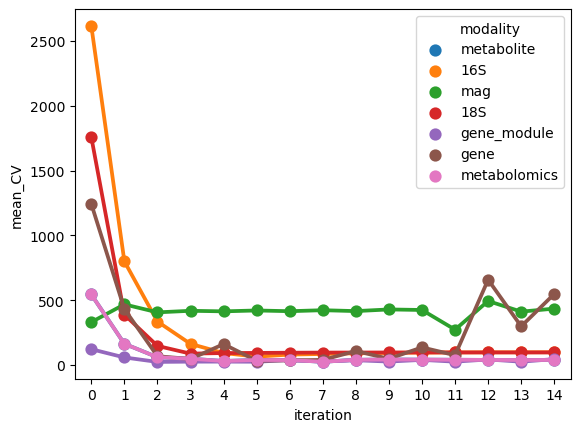

In [3]:
# check indpendent analysis
fold = 0
rpca_independent = {tblid:joint_rpca([tbl],
                                     n_components=3,
                                     max_iterations=15,
                                     min_feature_count=10,
                                     sample_metadata=metadata,
                                     train_test_column='traintest_%i' % fold)
                    for tblid, tbl in tables.items()}

cvs_ind = {(fold, datatype_):cv_tmp_dt for datatype_, (_, _, cv_tmp_dt) in rpca_independent.items()}
cvs_ind_all = pd.concat(cvs_ind).reset_index().rename({'level_0':'fold', 'level_1':'modality'}, axis=1)
sns.pointplot(x='iteration', y='mean_CV', hue='modality', data=cvs_ind_all)
plt.show()

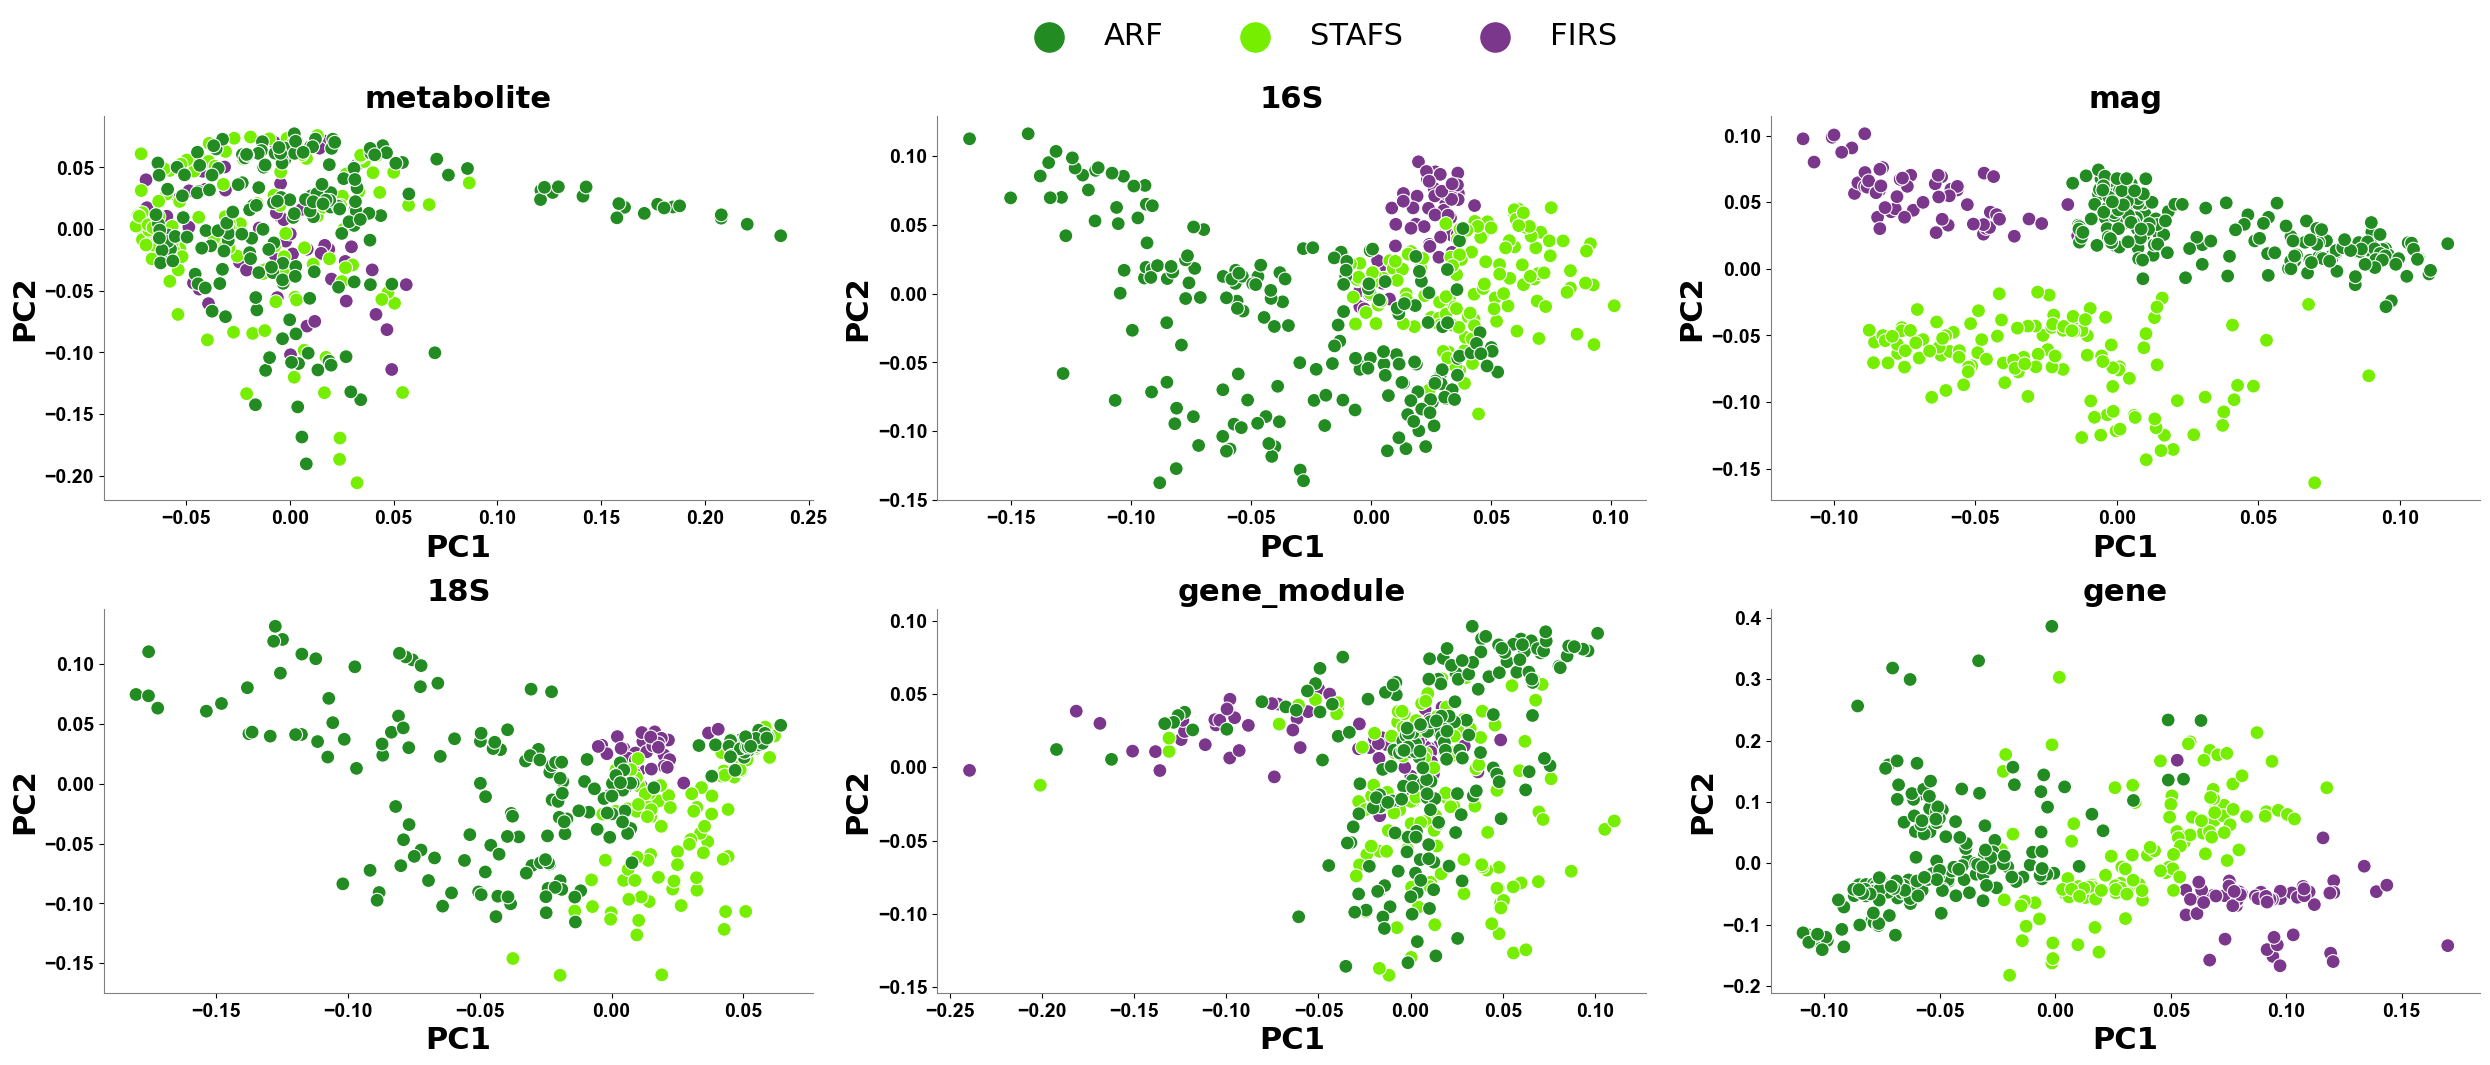

In [4]:
palette=["#228b22","#76ee00","#7a378b"]

fig, axn = plt.subplots(2, 3, figsize=(25, 10))
axn = axn.flatten()

for ax, (tblid, (ord_, dist_, _)) in zip(axn, rpca_independent.items()):
    
    ord_.write('../results/joint-rpca/%s_ord.txt' % tblid)
    dist_.write('../results/joint-rpca/%s_dist.txt' % tblid)
    
    ord_plt = pd.concat([ord_.samples, metadata], axis=1, sort=True)
    sns.scatterplot(x='PC1', y='PC2', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], palette=palette, data=ord_plt, s=100, ax=ax)
    
    ax.set_xlabel('PC1',
                  color='black',
                  weight='bold',
                  fontsize=22)
    ax.set_ylabel('PC2',
                  color='black',
                  weight='bold',
                  fontsize=22)

    ax.set_title(tblid,
                  color='black',
                  weight='bold',
                  fontsize=22)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    ax.legend_.remove()
    
plt.tight_layout()

legend = ax.legend(loc=2, 
           bbox_to_anchor=(-1.1, 2.6),
           prop={'size':22},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=3, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    

plt.show()

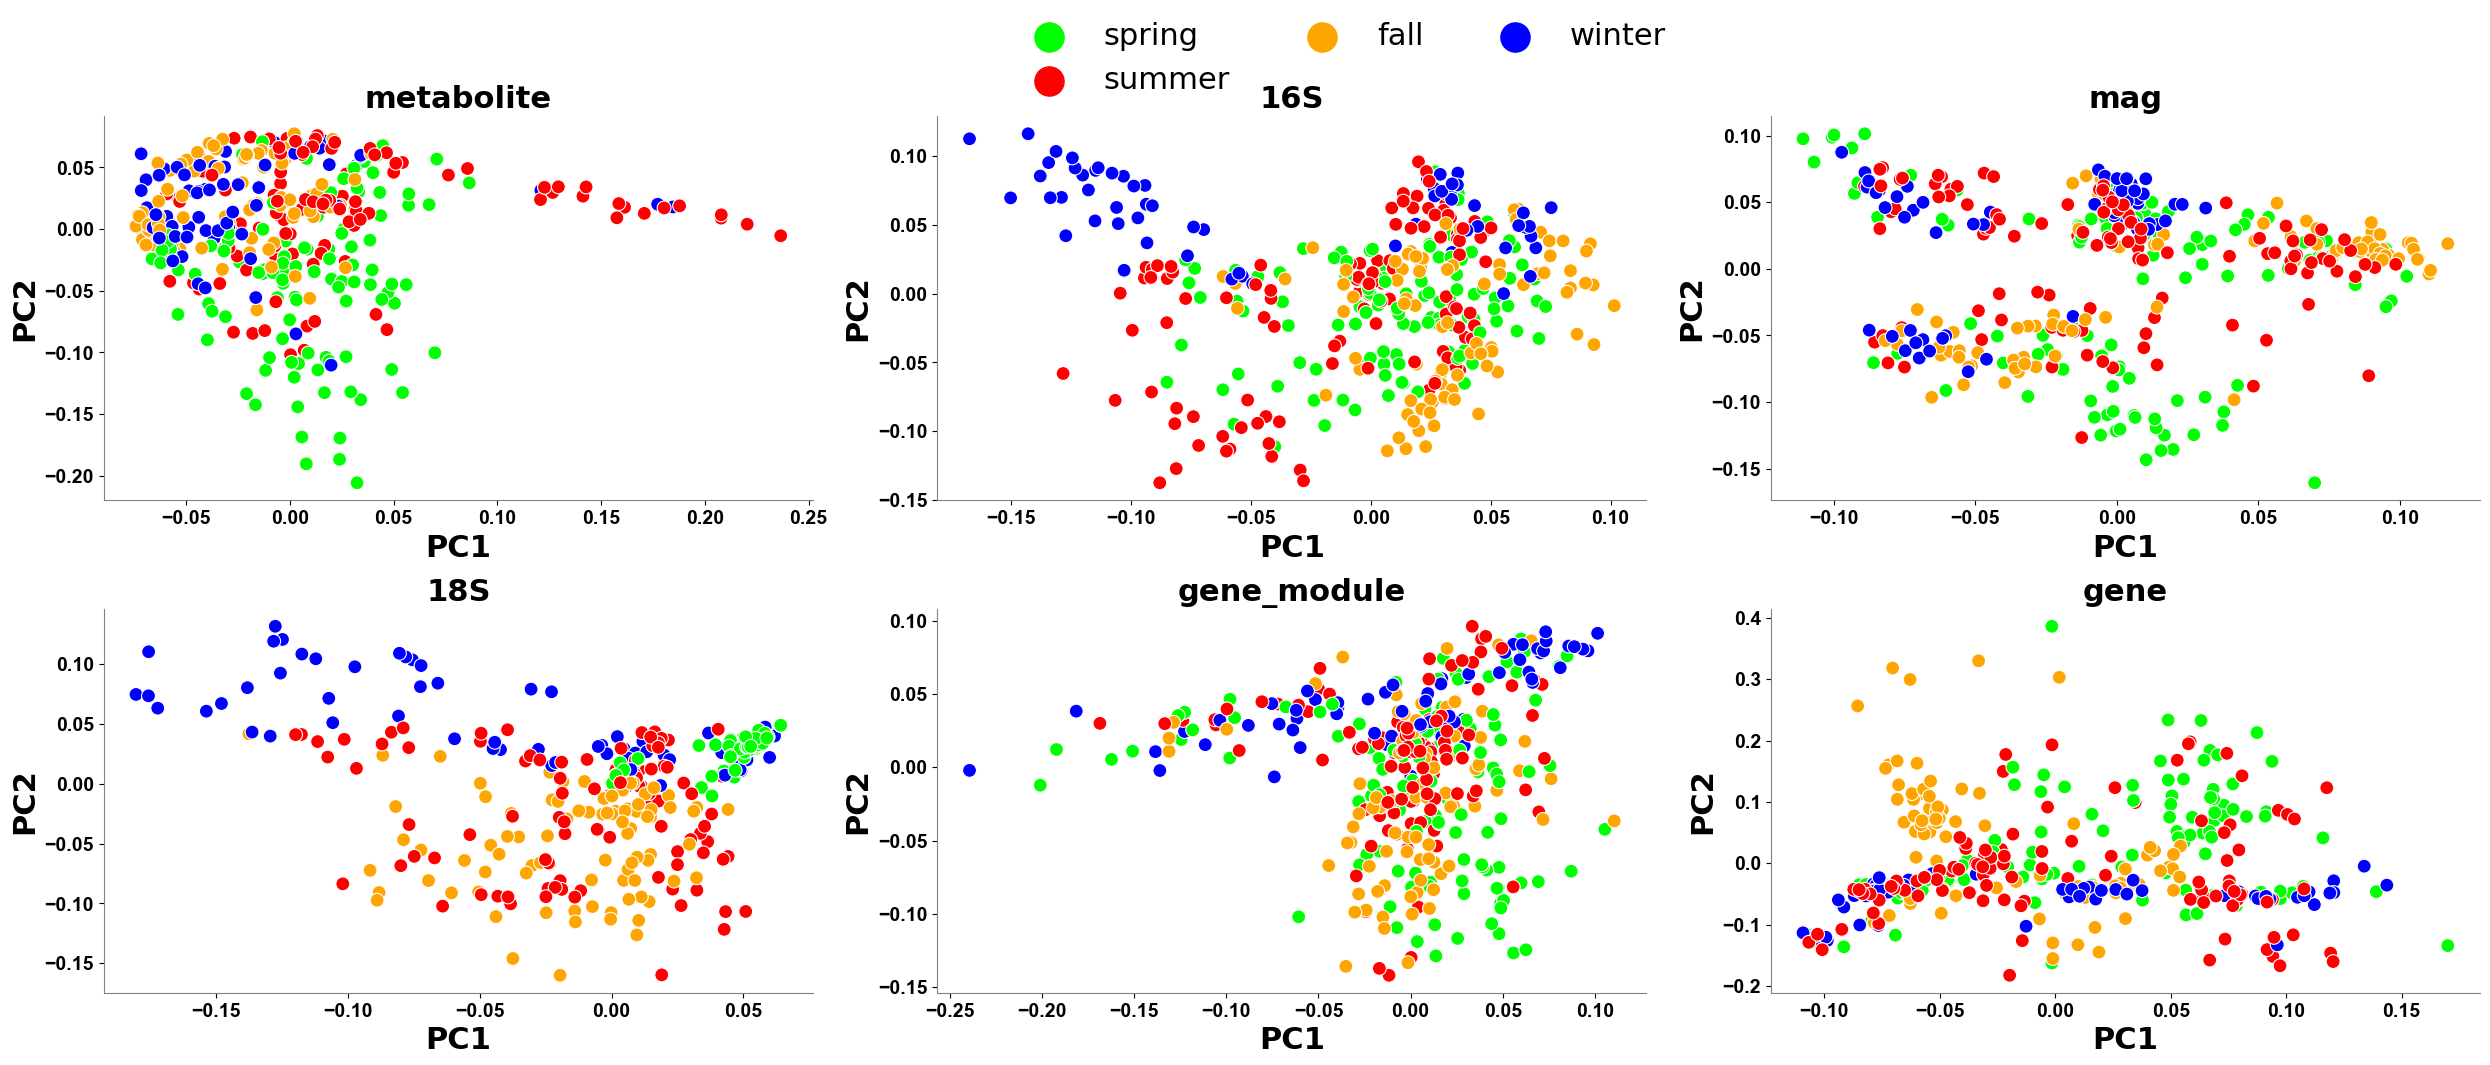

In [5]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]

fig, axn = plt.subplots(2, 3, figsize=(25, 10))
axn = axn.flatten()

for ax, (tblid, (ord_, dist_, _)) in zip(axn, rpca_independent.items()):
    
    ord_plt = pd.concat([ord_.samples, metadata], axis=1, sort=True)
    sns.scatterplot(x='PC1', y='PC2', hue='season', hue_order = ['spring', 'summer', 'fall','winter'], palette=palette, data=ord_plt, s=100, ax=ax)
    
    ax.set_xlabel('PC1',
                  color='black',
                  weight='bold',
                  fontsize=22)
    ax.set_ylabel('PC2',
                  color='black',
                  weight='bold',
                  fontsize=22)

    ax.set_title(tblid,
                  color='black',
                  weight='bold',
                  fontsize=22)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    ax.legend_.remove()
    
plt.tight_layout()

legend = ax.legend(loc=2, 
           bbox_to_anchor=(-1.1, 2.6),
           prop={'size':22},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=3, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    

plt.show()

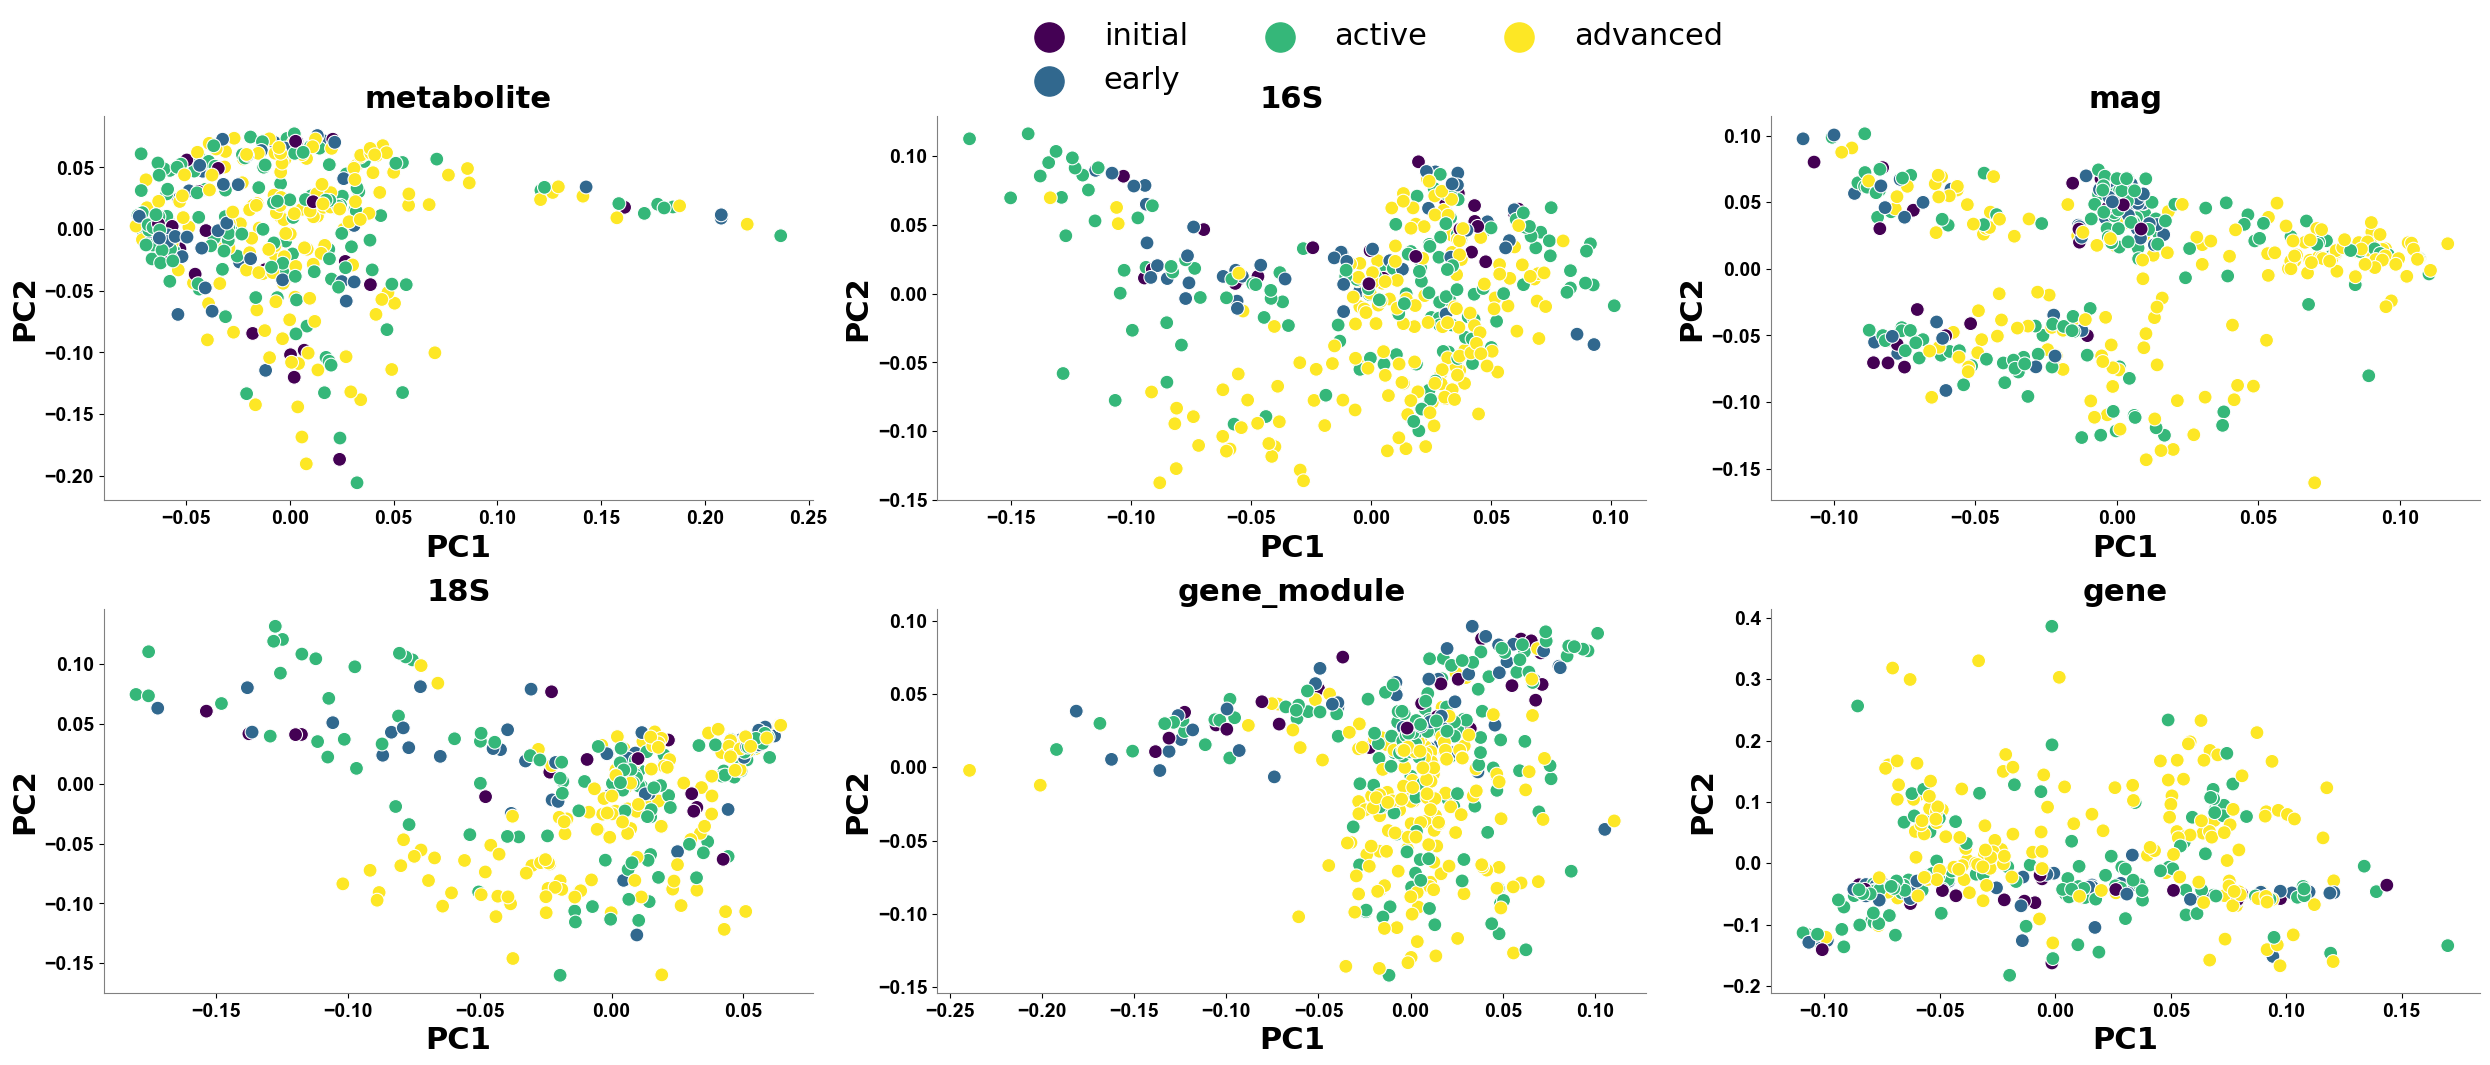

In [6]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]

fig, axn = plt.subplots(2, 3, figsize=(25, 10))
axn = axn.flatten()

for ax, (tblid, (ord_, dist_, _)) in zip(axn, rpca_independent.items()):
    
    ord_plt = pd.concat([ord_.samples, metadata], axis=1, sort=True)
    sns.scatterplot(x='PC1', y='PC2', hue='add_0c_group', hue_order = ['initial', 'early', 'active', 'advanced'], palette=palette, data=ord_plt, s=100, ax=ax)
    
    ax.set_xlabel('PC1',
                  color='black',
                  weight='bold',
                  fontsize=22)
    ax.set_ylabel('PC2',
                  color='black',
                  weight='bold',
                  fontsize=22)

    ax.set_title(tblid,
                  color='black',
                  weight='bold',
                  fontsize=22)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    ax.legend_.remove()
    
plt.tight_layout()

legend = ax.legend(loc=2, 
           bbox_to_anchor=(-1.1, 2.6),
           prop={'size':22},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=3, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    

plt.show()

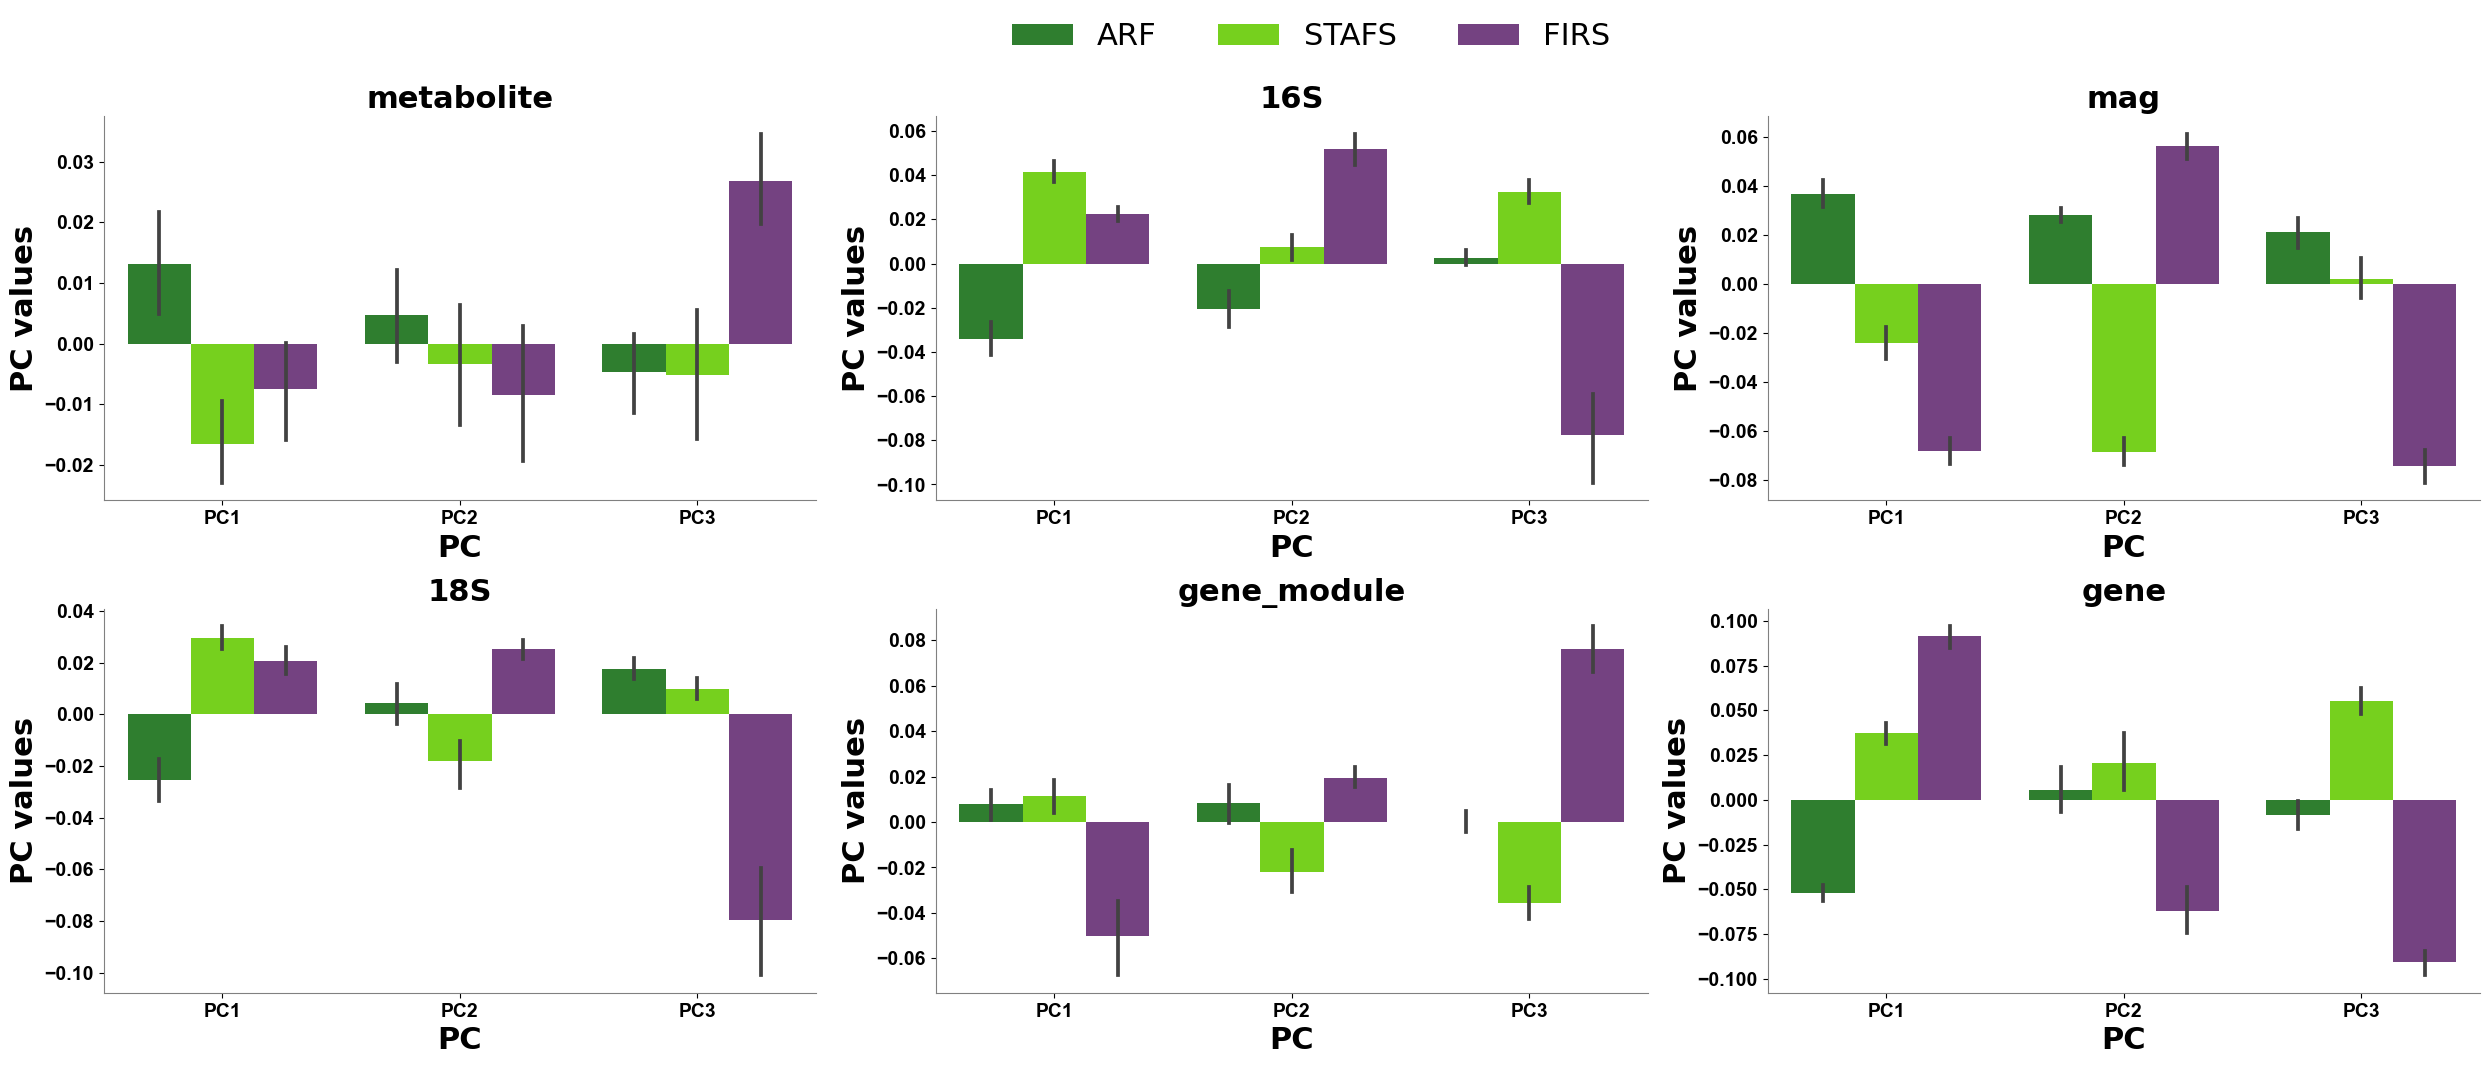

In [7]:
palette=["#228b22","#76ee00","#7a378b"]
fig, axn = plt.subplots(2, 3, figsize=(25, 10))
axn = axn.flatten()

for ax, (tblid, (ord_, dist_, _)) in zip(axn, rpca_independent.items()):
    
    ord_plt = ord_.samples
    ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                         for c in ord_plt.columns}, axis=0).reset_index()
    sns.barplot(x='level_0', y='PC', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], data=ord_plt, ax=ax, palette=palette)
    
    ax.set_xlabel('PC',
                  color='black',
                  weight='bold',
                  fontsize=22)
    ax.set_ylabel('PC values',
                  color='black',
                  weight='bold',
                  fontsize=22)

    ax.set_title(tblid,
                  color='black',
                  weight='bold',
                  fontsize=22)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    ax.legend_.remove()
    
plt.tight_layout()

legend = ax.legend(loc=2, 
           bbox_to_anchor=(-1.1, 2.6),
           prop={'size':22},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=3, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    

plt.show()


# joint-rpca

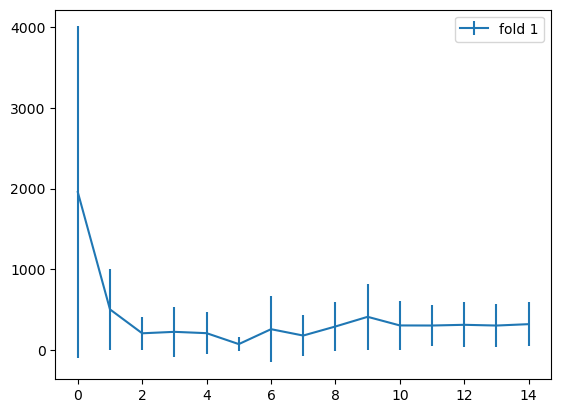

In [8]:
cv_all_joint = {}
fold = 0
ord_jnt, dist_jnt, cv_jnt = joint_rpca([v for k, v in tables.items()
                                        if k in ['mag', '18S', 'gene_module', 'gene', 'metabolite']],
                            n_components=4,
                            max_iterations=15,
                            min_feature_count=10,
                            sample_metadata=metadata,
                            train_test_column='traintest_%i' % fold)
cv_all_joint[0] = cv_jnt

# check CV error
cv_all_joint_df = pd.concat(cv_all_joint).reset_index().rename({'level_0':'fold'}, axis=1)
for f, df_ in cv_all_joint_df.groupby('fold'):
    plt.errorbar(df_.iteration, df_['mean_CV'], yerr=df_['std_CV'], label='fold %i' % (f + 1))
plt.legend()
plt.show()


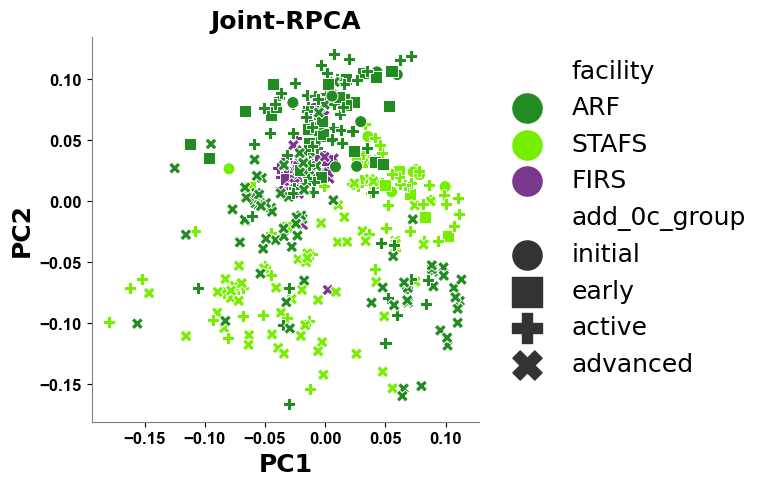

In [9]:
palette=["#228b22","#76ee00","#7a378b"]
markers = {"initial": "o", "early": "s", "active": "P", "advanced": "X"}

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
sns.scatterplot(x='PC1', y='PC2', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], palette=palette, style='add_0c_group', style_order = ['initial', 'early', 'active', 'advanced'], markers=markers, data=ord_plt, s=75, ax=ax)

ax.set_xlabel('PC1',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/joint-rpca.png',
#            dpi=600, 
#            bbox_inches='tight')
plt.show()

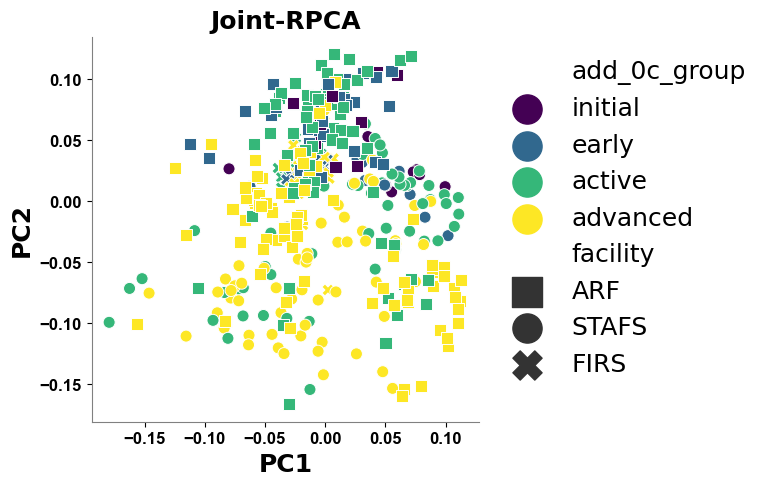

In [10]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
sns.scatterplot(x='PC1', y='PC2', hue='add_0c_group', hue_order = ['initial', 'early', 'active', 'advanced'], palette=palette, style='facility', style_order = ['ARF', 'STAFS', 'FIRS'], markers=markers, data=ord_plt, s=75, ax=ax)

ax.set_xlabel('PC1',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/joint-rpca-time.png',
#            dpi=600, 
#            bbox_inches='tight')
plt.show()

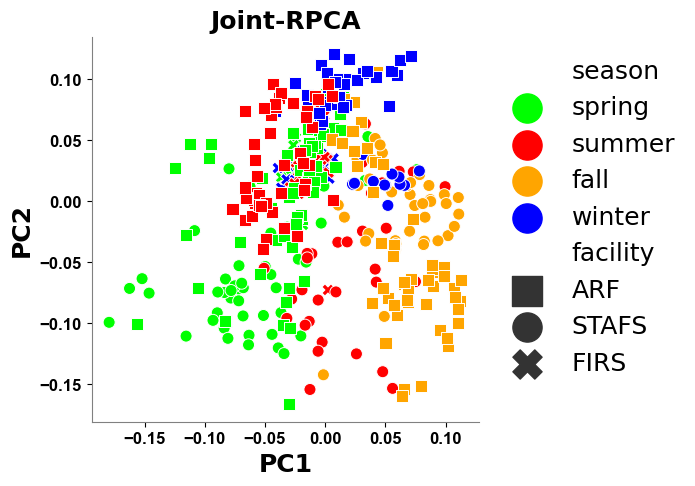

In [11]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
sns.scatterplot(x='PC1', y='PC2', hue='season', hue_order = ['spring', 'summer','fall','winter'], palette=palette, style='facility', style_order = ['ARF', 'STAFS', 'FIRS'], markers=markers, data=ord_plt, s=75, ax=ax)

ax.set_xlabel('PC1',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/joint-rpca-season-facility.png',
#            dpi=600, 
#            bbox_inches='tight')
plt.show()

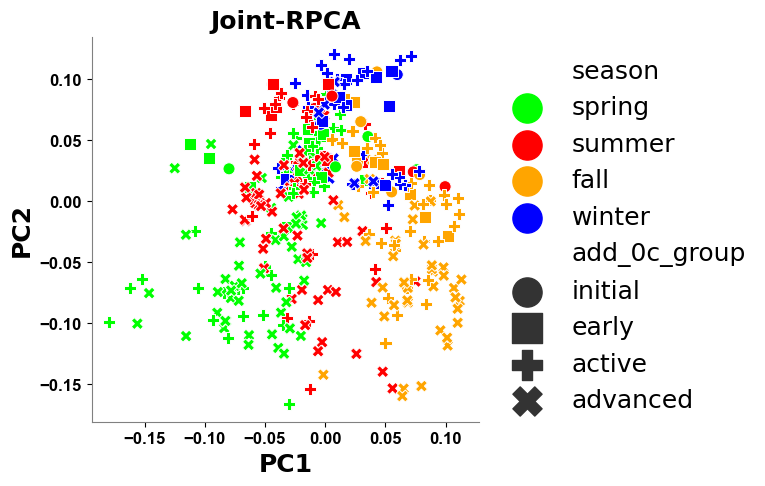

In [12]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]
markers = {"initial": "o", "early": "s", "active": "P", "advanced": "X"}

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
sns.scatterplot(x='PC1', y='PC2', hue='season', hue_order = ['spring', 'summer','fall','winter'], palette=palette, style='add_0c_group', style_order = ['initial', 'early', 'active','advanced'], markers=markers, data=ord_plt, s=75, ax=ax)

ax.set_xlabel('PC1',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/joint-rpca-season-stage.png',
#            dpi=600, 
#            bbox_inches='tight')
plt.show()

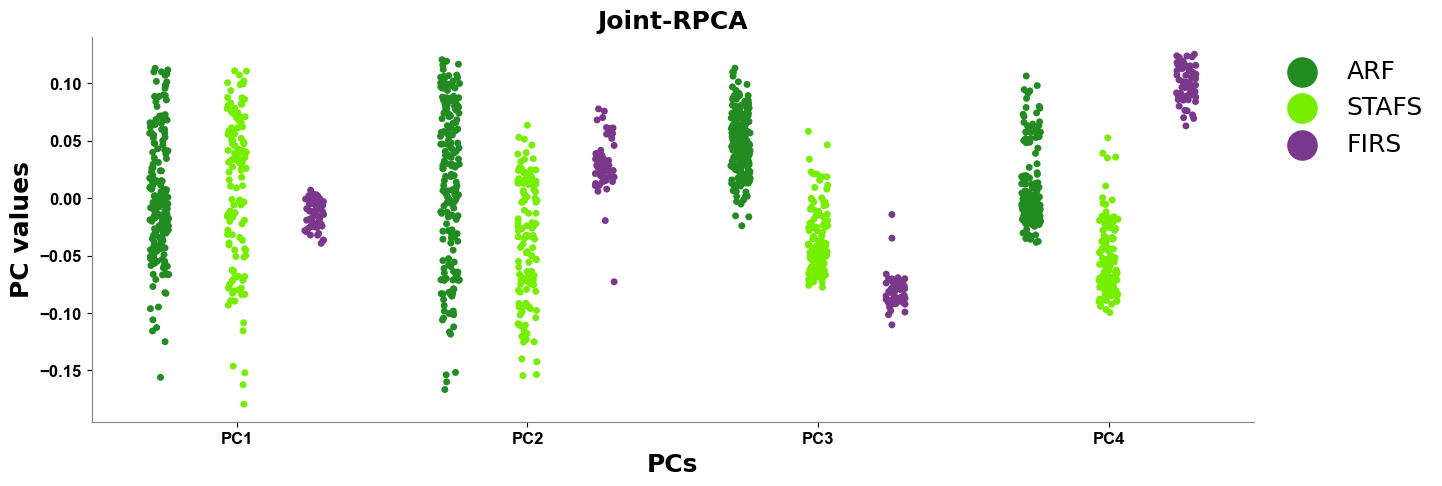

In [13]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
sns.stripplot(x='level_0', y='PC', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], palette=palette, data=ord_plt, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-location.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

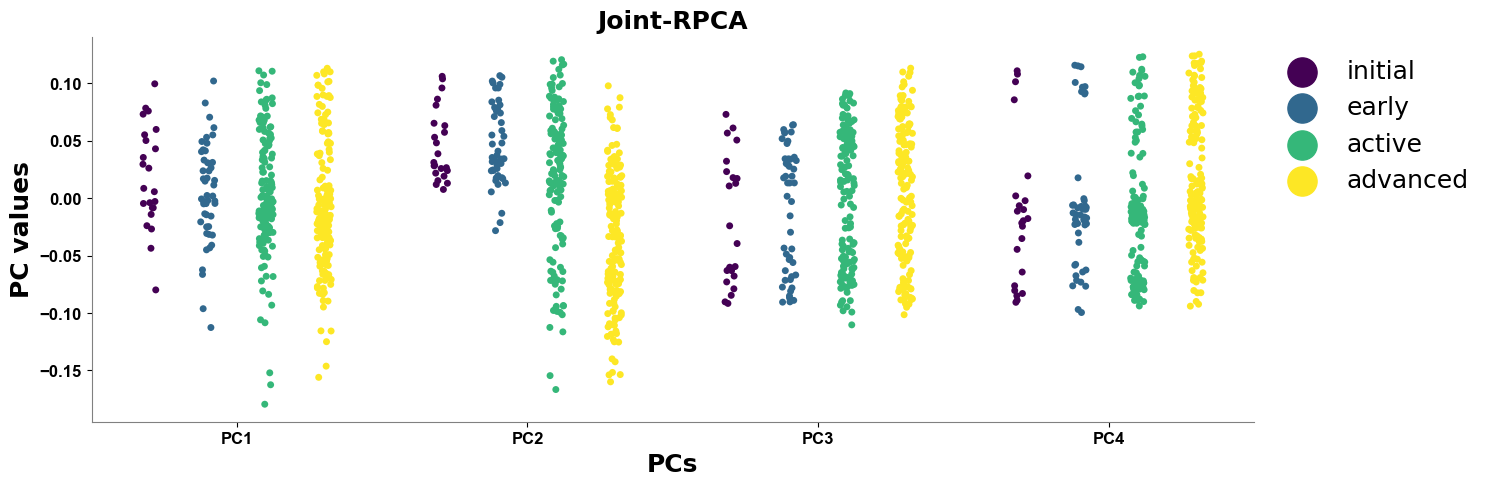

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]


ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
sns.stripplot(x='level_0', y='PC', hue='add_0c_group', data=ord_plt, palette=palette,
              hue_order = ['initial', 'early', 'active', 'advanced'], ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

In [15]:
ord_plt.head()

,level_0,level_1,index,PC,season,subjects,add_0c,add_0c_group,facility,timepoint,traintest_0,traintest_1,traintest_2,traintest_3,traintest_4,traintest_5,traintest_6,traintest_7,traintest_8,traintest_9
0,PC1,0,soil.hip.CMU.16.05.2016.mo.day1,-0.008345,spring,CMU_Mrs._16_05,0.000000,initial,FIRS,1,train,train,train,train,train,train,train,train,train,train
1,PC1,1,soil.hip.CMU.16.05.2016.mo.day10,-0.022337,spring,CMU_Mrs._16_05,79.722222,active,FIRS,10,train,train,train,train,train,train,train,train,train,train
2,PC1,2,soil.hip.CMU.16.05.2016.mo.day12,-0.006294,spring,CMU_Mrs._16_05,110.277778,active,FIRS,12,test,test,test,test,test,test,test,test,test,test
3,PC1,3,soil.hip.CMU.16.05.2016.mo.day13,-0.011633,spring,CMU_Mrs._16_05,123.333333,active,FIRS,13,train,train,train,train,train,train,train,train,train,train
4,PC1,4,soil.hip.CMU.16.05.2016.mo.day14,-0.024302,spring,CMU_Mrs._16_05,136.666667,active,FIRS,14,train,train,train,train,train,train,train,train,train,train


In [16]:
# palette=["#228b22","#76ee00","#7a378b"]

# fig, ax = plt.subplots(1,1, figsize=(15, 5))

# ord_plt = ord_jnt.samples
# ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
#                      for c in ord_plt.columns}, axis=0).reset_index()
# sns.stripplot(x='level_0', y='PC', hue='climate', data=ord_plt,
#               hue_order = ['temperate', 'semi-arid'], ax=ax, dodge=True)

# ax.set_xlabel('PCs',
#               color='black',
#               weight='bold',
#               fontsize=18)
# ax.set_ylabel('PC values',
#               color='black',
#               weight='bold',
#               fontsize=18)

# ax.set_title('Joint-RPCA',
#               color='black',
#               weight='bold',
#               fontsize=18)

# # fix backround
# ax.set_facecolor('white')
# ax.set_axisbelow(True)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(True)
# ax.spines['bottom'].set_visible(True)
# ax.spines['top'].set_visible(False)
# for child in ax.get_children():
#     if isinstance(child, matplotlib.spines.Spine):
#         child.set_color('grey')

# for tick in ax.get_yticklabels():
#     tick.set_fontproperties('arial')
#     tick.set_weight('bold')
#     tick.set_color("black")
#     tick.set_fontsize(12)
# for tick in ax.get_xticklabels():
#     tick.set_fontproperties('arial')
#     tick.set_weight('bold')
#     tick.set_color("black")
#     tick.set_fontsize(12)

# legend = ax.legend(loc=2, 
#            bbox_to_anchor=(1, 1),
#            prop={'size':18},
#            title="",
#            fancybox=True,
#                     framealpha=.0,
#            ncol=1, markerscale=3.5)
# legend.get_title().set_fontsize('16')
# # increase the line width in the legend 
# for line in legend.get_lines()[:]:
#     line.set_linewidth(2.0)
# for line in legend.get_lines()[:]:
#     line.set_linewidth(2.0)
# #plt.savefig('../results/figures/rpca-pc-loadings-climate.png',
# #            dpi=600, 
# #            bbox_inches='tight',
# #            edgecolor='none')

# plt.show()

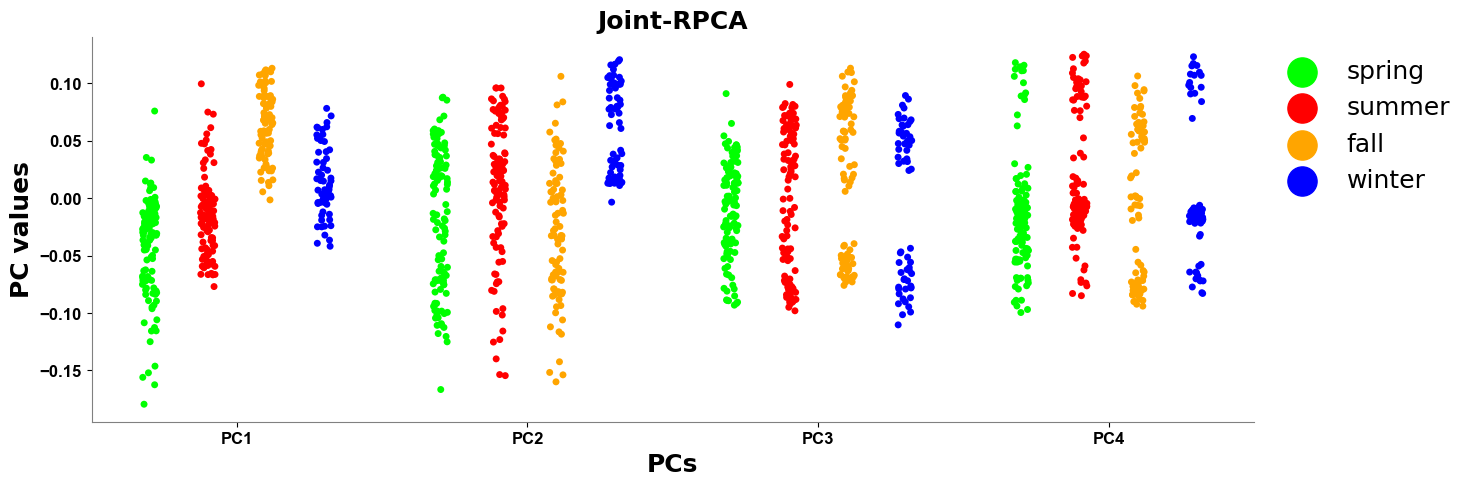

In [17]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
#ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='season', data=ord_plt,
              hue_order = ['spring', 'summer','fall','winter'], palette=palette, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-seasons.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

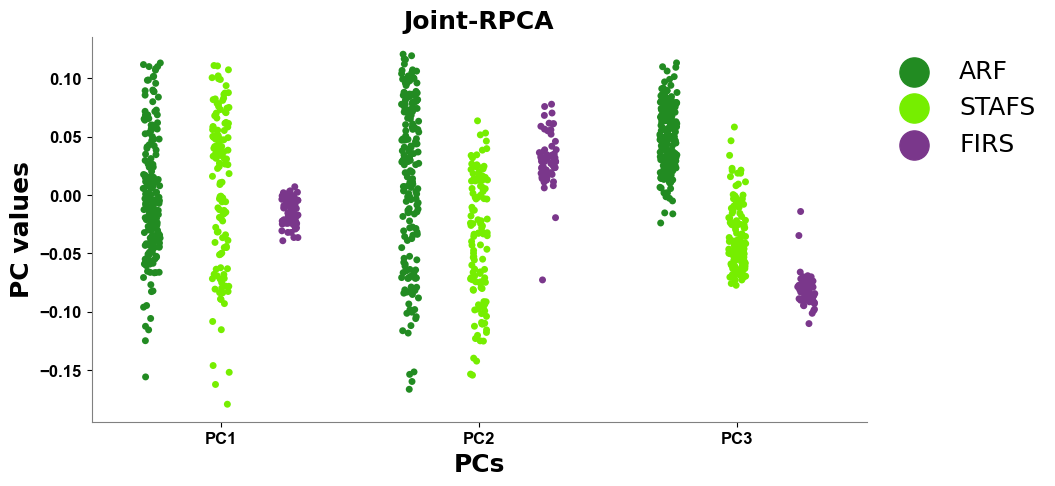

In [18]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(10, 5))

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()

ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], palette=palette, data=ord_plt, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-location-PC3.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

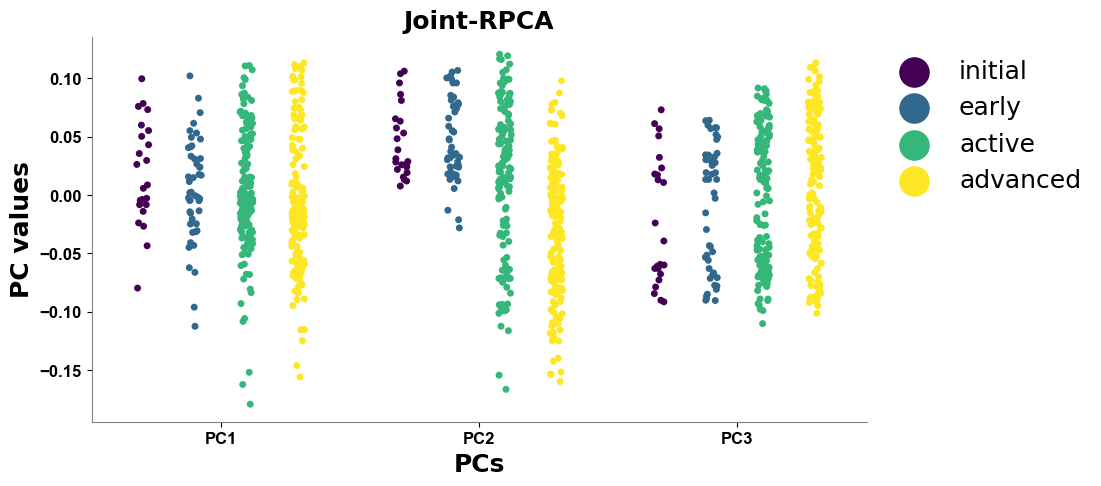

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='add_0c_group', data=ord_plt, palette=palette,
              hue_order = ['initial', 'early', 'active', 'advanced'], ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-time-PC3.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

In [20]:
# palette=["#228b22","#76ee00","#7a378b"]

# fig, ax = plt.subplots(1,1, figsize=(10, 5))

# ord_plt = ord_jnt.samples
# ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
#                      for c in ord_plt.columns}, axis=0).reset_index()
# ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]


# sns.stripplot(x='level_0', y='PC', hue='climate', data=ord_plt,
#               hue_order = ['temperate', 'semi-arid'], ax=ax, dodge=True)

# ax.set_xlabel('PCs',
#               color='black',
#               weight='bold',
#               fontsize=18)
# ax.set_ylabel('PC values',
#               color='black',
#               weight='bold',
#               fontsize=18)

# ax.set_title('Joint-RPCA',
#               color='black',
#               weight='bold',
#               fontsize=18)

# # fix backround
# ax.set_facecolor('white')
# ax.set_axisbelow(True)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(True)
# ax.spines['bottom'].set_visible(True)
# ax.spines['top'].set_visible(False)
# for child in ax.get_children():
#     if isinstance(child, matplotlib.spines.Spine):
#         child.set_color('grey')

# for tick in ax.get_yticklabels():
#     tick.set_fontproperties('arial')
#     tick.set_weight('bold')
#     tick.set_color("black")
#     tick.set_fontsize(12)
# for tick in ax.get_xticklabels():
#     tick.set_fontproperties('arial')
#     tick.set_weight('bold')
#     tick.set_color("black")
#     tick.set_fontsize(12)

# legend = ax.legend(loc=2, 
#            bbox_to_anchor=(1, 1),
#            prop={'size':18},
#            title="",
#            fancybox=True,
#                     framealpha=.0,
#            ncol=1, markerscale=3.5)
# legend.get_title().set_fontsize('16')
# # increase the line width in the legend 
# for line in legend.get_lines()[:]:
#     line.set_linewidth(2.0)
# for line in legend.get_lines()[:]:
#     line.set_linewidth(2.0)
# #plt.savefig('../results/figures/rpca-pc-loadings-climate-PC3.png',
# #            dpi=600, 
# #            bbox_inches='tight',
# #            edgecolor='none')

# plt.show()

In [35]:
ord_jnt.samples

,PC1,PC2,PC3,PC4
soil.hip.CMU.17.10.2017.08.14.day6,-0.009173,0.023402,-0.070344,0.088893
soil.hip.UTK.K016.02.2016.04.14.day2,-0.014415,0.058862,0.019099,-0.006779
soil.hip.SHSU.2016.024.2016.05.01.day17,-0.078130,-0.073305,-0.015777,-0.069779
soil.hip.SHSU.2016.024.2016.04.18.day4,-0.108474,-0.024133,-0.039869,-0.093851
soil.hip.CMU.16.05.2016.mo.day9,-0.036530,0.019627,-0.089293,0.111114
...,...,...,...,...
soil.hip.UTK.K016.07.2017.Jan.11.day5,0.016908,0.100324,0.030179,-0.006153
soil.hip.UTK.K016.08.2017.Jan.26.day20,0.007852,0.097875,0.031874,-0.010452
soil.hip.SHSU.2016.011.2016.04.27.day13,-0.034173,-0.125068,0.022836,-0.053047
soil.hip.UTK.K016.12.2017.06.14.day21,-0.034248,0.029582,0.032261,-0.013245


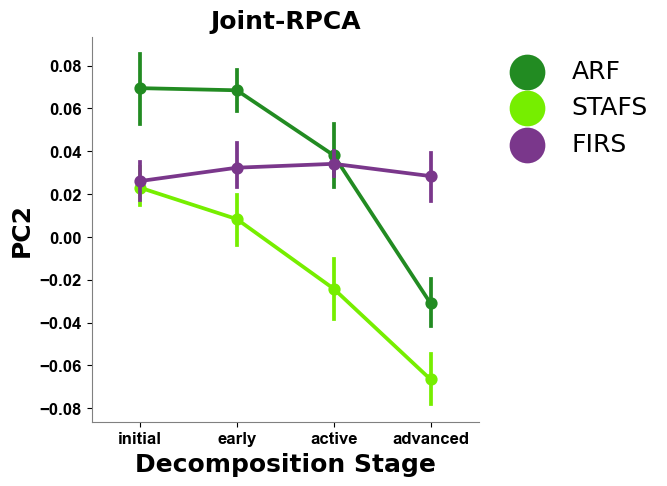

In [22]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
sns.pointplot(x='add_0c_group', y='PC2', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], 
              order = ['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc2-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

In [23]:
ord_jnt.write('../results/joint-rpca/ord.txt')
dist_jnt.write('../results/joint-rpca/dist.txt')
cv_jnt.to_csv('../results/joint-rpca/cv.csv')


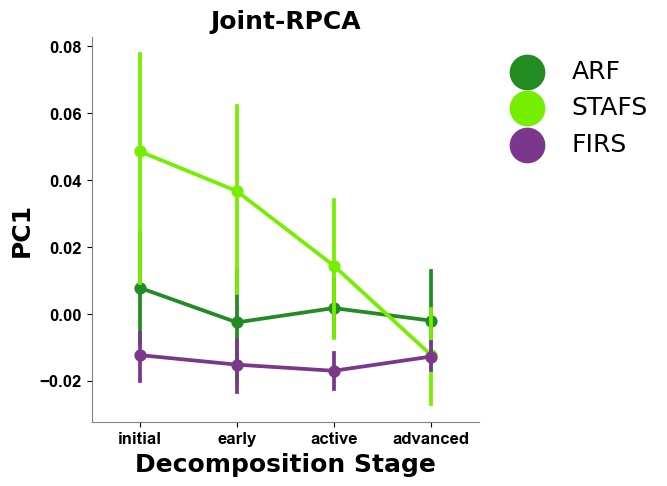

In [24]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
sns.pointplot(x='add_0c_group', y='PC1', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], 
              order = ['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC1',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc1-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

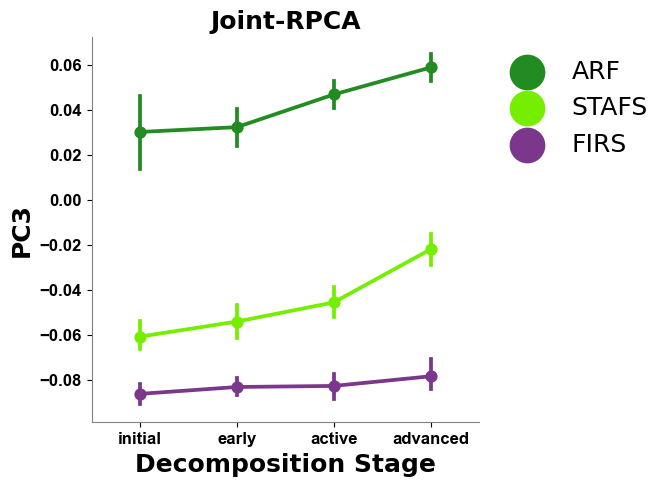

In [25]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
sns.pointplot(x='add_0c_group', y='PC3', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], 
              order = ['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC3',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc3-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

In [26]:
metadata_subset = pd.read_csv('../network/split-matched-data/metadata.tsv', sep='\t', index_col=0)
ord_joint = OrdinationResults.read('../results/joint-rpca/ord.txt')
ord_joint_samps = ord_joint.samples.copy()
ord_joint_samps.index.name = 'sample_name'
ord_joint_samps.reset_index(inplace=True)
merged_table = pd.merge(ord_joint_samps, metadata_subset, on='sample_name')
merged_table.head()

,sample_name,0,1,2,3,season,subjects,add_0c,add_0c_group,facility,...,traintest_0,traintest_1,traintest_2,traintest_3,traintest_4,traintest_5,traintest_6,traintest_7,traintest_8,traintest_9
0,soil.hip.CMU.17.10.2017.08.14.day6,-0.009173,0.023402,-0.070344,0.088893,summer,17-10,122.550000,active,FIRS,...,train,train,train,train,train,train,train,train,train,train
1,soil.hip.UTK.K016.02.2016.04.14.day2,-0.014415,0.058862,0.019099,-0.006779,spring,UTK.K016.02,18.611111,early,ARF,...,train,train,train,train,train,train,train,train,train,train
2,soil.hip.SHSU.2016.024.2016.05.01.day17,-0.078130,-0.073305,-0.015777,-0.069779,spring,shsu.2016.024,373.611111,advanced,STAFS,...,train,train,train,train,train,train,train,train,train,train
3,soil.hip.SHSU.2016.024.2016.04.18.day4,-0.108474,-0.024133,-0.039869,-0.093851,spring,shsu.2016.024,67.500000,active,STAFS,...,train,train,train,train,train,train,train,train,train,train
4,soil.hip.CMU.16.05.2016.mo.day9,-0.036530,0.019627,-0.089293,0.111114,spring,CMU_Mrs._16_05,69.444444,active,FIRS,...,train,train,train,train,train,train,train,train,train,train


In [27]:
# Group the numerical data based on the categorical data
for i in range (4):
    grouped = merged_table.groupby('facility')[i]
    groups = [group for _, group in grouped]

    # Perform the Kruskal-Wallis test
    h, p = kruskal(*groups)
    print("Facility Kruskal Wallis Tests by Axis")
    print("Axis ",i+1)
    print("H-statistic:", h)
    print("p-value:", p)

Facility Kruskal Wallis Tests by Axis
Axis  1
H-statistic: 8.297189199772447
p-value: 0.015786587373411345
Facility Kruskal Wallis Tests by Axis
Axis  2
H-statistic: 72.67934701547529
p-value: 1.6515066296601067e-16
Facility Kruskal Wallis Tests by Axis
Axis  3
H-statistic: 289.1008622217296
p-value: 1.6693423521486925e-63
Facility Kruskal Wallis Tests by Axis
Axis  4
H-statistic: 260.92710466280437
p-value: 2.1897731834381305e-57


In [29]:
# # Group the numerical data based on the categorical data
# for i in range (4):
#     grouped = merged_table.groupby('climate')[i]
#     groups = [group for _, group in grouped]

#     # Perform the Wilcox test
#     u, p = mannwhitneyu(*groups)
#     print("Climate Wilcox Tests by Axis")
#     print("Axis ",i+1)
#     print("U-statistic:", u)
#     print("p-value:", p)

In [30]:
# Group the numerical data based on the categorical data
for i in range (4):
    grouped = merged_table.groupby('season')[i]
    groups = [group for _, group in grouped]

    # Perform the Kruskal-Wallis test
    h, p = kruskal(*groups)
    print("Season Kruskal Wallis Tests by Axis")
    print("Axis ",i+1)
    print("H-statistic:", h)
    print("p-value:", p)

Season Kruskal Wallis Tests by Axis
Axis  1
H-statistic: 214.83216299379387
p-value: 2.6289714736555725e-46
Season Kruskal Wallis Tests by Axis
Axis  2
H-statistic: 86.14345496889109
p-value: 1.474667706952892e-18
Season Kruskal Wallis Tests by Axis
Axis  3
H-statistic: 10.976511015691585
p-value: 0.011853569825849243
Season Kruskal Wallis Tests by Axis
Axis  4
H-statistic: 15.475195490108263
p-value: 0.0014524648541726479


In [31]:
# Group the numerical data based on the categorical data
for i in range (4):
    grouped = merged_table.groupby('add_0c_group')[i]
    groups = [group for _, group in grouped]

    # Perform the Kruskal-Wallis test
    h, p = kruskal(*groups)
    print("Decomp Stage Kruskal Wallis Tests by Axis")
    print("Axis ",i+1)
    print("H-statistic:", h)
    print("p-value:", p)

Decomp Stage Kruskal Wallis Tests by Axis
Axis  1
H-statistic: 10.533132688934302
p-value: 0.014537815239844366
Decomp Stage Kruskal Wallis Tests by Axis
Axis  2
H-statistic: 95.3114190364488
p-value: 1.5826606458284783e-20
Decomp Stage Kruskal Wallis Tests by Axis
Axis  3
H-statistic: 9.904242680018797
p-value: 0.019397893326158645
Decomp Stage Kruskal Wallis Tests by Axis
Axis  4
H-statistic: 18.782293809964813
p-value: 0.0003032486357921448
